# Visualisation of Vacancy Estimates Across Vintages

In this section, we visualise how vacancy estimates have changed across different vintages to explore overall patterns, trends, and possible revisions over time.

Each ONS release (vintage) includes data only up to **roughly one or two months prior to its publication date, reflecting the reporting lag** typical in official statistics.
This lag causes later vintages to extend the series with new months while slightly revising recent values near the series end.

By exploring **potential trend, seasonality, or other structural patterns**, we aim to understand the underlying behaviour of the data and draw **implications for subsequent time-series forecasting**.

Both observation_month and vintage_date are stored as **datetime** objects for consistency and compatibility with time-series plotting and forecasting functions. So each observation month is **represented as the first day (e.g. 2001-05-01)** purely for alignment — **this does not imply daily frequency**.

## 0. Data/Package preparation

In [1]:
TIDY_CSV = "../data/processed/AP2Y_tidy.csv"  # Path to the tidy dataset

In [2]:
# Select observation months for plotting
SINGLE_MONTH = "2023-01" # Single observation
MULTI_MONTHS = ["2001-01", "2007-01", "2012-01", "2017-01", "2023-01", "2025-01"] # Multiple observations

In [3]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
# Load tidy data
df = pd.read_csv(TIDY_CSV, parse_dates=["observation_month","vintage_date"])

# Basic sanity display
display(df.head())
print("[info] rows:", len(df), " vintage date range:", df["vintage_date"].min().date(), "→", df["vintage_date"].max().date())
print("observation month range:", df["observation_month"].min().date(), "→", df["observation_month"].max().date()) 

,observation_month,vintage_date,value
0,2001-05-01,2023-03-14,680.0
1,2001-05-01,2023-04-18,680.0
2,2001-05-01,2023-05-16,680.0
3,2001-05-01,2023-06-13,680.0
4,2001-05-01,2023-07-11,680.0


[info] rows: 8288  vintage date range: 2023-03-14 → 2025-09-16
observation month range: 2001-05-01 → 2025-07-01


## 1. Single observation (2023 Jan)

We first plot the revisions for the observation month **2023-01** across all vintages.  
This shows how the estimate for a single month evolves as new vintages are released.

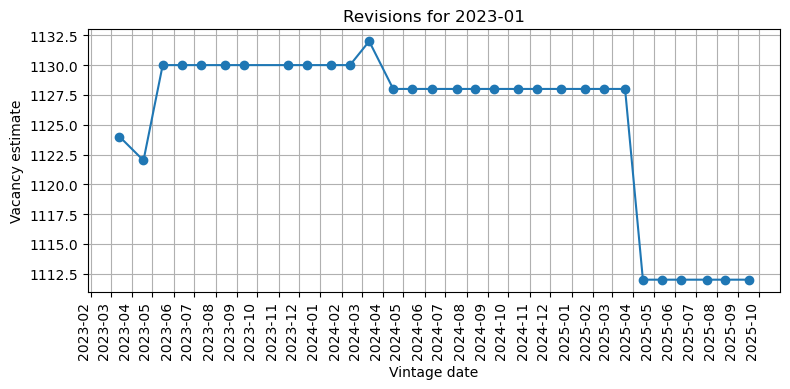

In [5]:
# Single observation

# Filter and sort by vintage for the chosen observation month
sub = df[df["observation_month"] == SINGLE_MONTH].sort_values("vintage_date")

# Plot
if sub.empty:
    print(f"[warn] No data found for observation_month={SINGLE_MONTH}")
else:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(sub["vintage_date"], sub["value"], marker="o")

    ax.set_title(f"Revisions for {SINGLE_MONTH}")
    ax.set_xlabel("Vintage date")
    ax.set_ylabel("Vacancy estimate")

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # Force monthly ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    fig.autofmt_xdate(rotation=90)  # auto-format + rotate ticks

    ax.grid(True)
    fig.tight_layout()
    plt.show()

### Interpretation

The visualization indicates that the series is **largely stable over time, without clear seasonality or persistent trend**.
However, there are **occasional structural level shifts** (around May 2023 and April 2025), suggesting that the process is mostly mean-reverting but can experience abrupt changes when data definitions or revisions occur.

The **absolute change is only about 10–15** on a level of roughly 1130 vacancies (**less than 1.5%**), confirming that these adjustments are **small in relative terms**.

To verify whether this revision behaviour is consistent across different periods, we examine several observation months at five-year intervals from 2007 to 2025.

## 2. Multiple observations (revisions relative to first release)

To check whether this revision pattern is consistent across different periods, we also examine several observation months at five-year intervals from 2007 to 2025 (**used Δ to make revision patterns more visible**). 

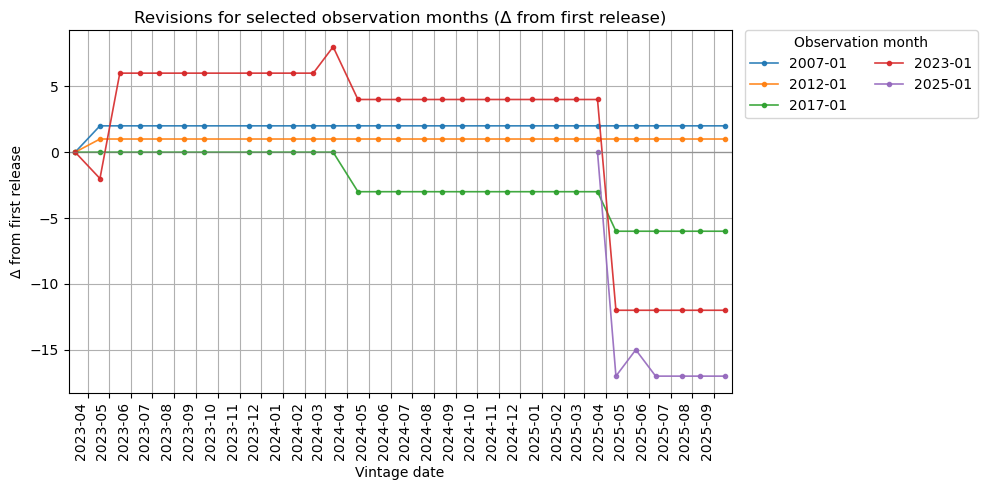

In [6]:
# Multiple Observations

colors = {}
fig, ax = plt.subplots(figsize=(10, 5))

for om in MULTI_MONTHS:
    sub = df[df["observation_month"] == om].sort_values("vintage_date")
    if sub.empty:
        continue

    # Compute delta
    y = sub["value"].astype(float).copy()
    y = y - y.iloc[0] # delta

    # Lines / markers
    line, = plt.plot(
        sub["vintage_date"], y,
        marker="o", markersize=3, linewidth=1.2, alpha=0.9
    )
    colors[om] = line

# Title / labels
ax.set_title("Revisions for selected observation months" + (" (Δ from first release)"))
ax.set_xlabel("Vintage date")
ax.set_ylabel("Δ from first release")

ax.axhline(0, color="gray", linewidth=1, alpha=0.6)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))     
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))     
fig.autofmt_xdate(rotation=90)                                   

# Legend
handles = [colors[k] for k in MULTI_MONTHS if k in colors]
labels = [k for k in MULTI_MONTHS if k in colors]
if handles:
    ax.legend(
        handles, labels, title="Observation month",
        ncol=2, loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0.0
    )

# Margins / padding
ax.margins(x=0.01, y=0.05)
ax.grid(True)
fig.tight_layout()
plt.show()

### Interpretation

The results show that, while **older months (e.g. 2007-01, 2012-01) remain stable with almost no revisions**, **more recent ones (e.g. 2023-01, 2025-01) display a sharp downward adjustment around May 2025**.
This indicates that the break observed earlier is not idiosyncratic but reflects a **systematic methodological or definitional change** that primarily affected recent data.

While the comparison between older and more recent observation months highlights differences in the magnitude of revisions,
**the overall pattern remains similar** — the series stays stable for long periods but occasionally undergoes sharp adjustments,
with **relatively small absolute changes** compared with the overall vacancy levels.

To confirm that this behaviour holds on average, we finally examine the average revision across all observation months, which summarises the aggregate revision tendency of the dataset.

## 3. Average revisions (overall patterns)

Finally, we compute the average revision across all months to summarise the overall revision tendency of the dataset.

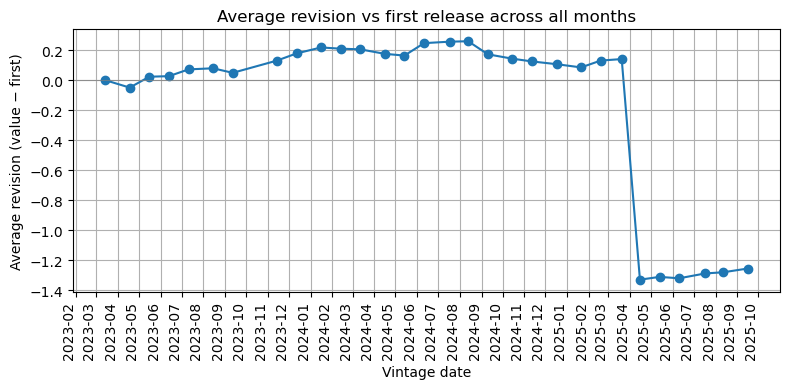

In [7]:
# Compute delta
tmp = df.sort_values(["observation_month", "vintage_date"]).copy()
tmp["first"] = tmp.groupby("observation_month")["value"].transform("first")
tmp["delta"] = tmp["value"] - tmp["first"]

# Average delta across all months
avg_profile = tmp.groupby("vintage_date", as_index=False)["delta"].mean()

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(avg_profile["vintage_date"], avg_profile["delta"], marker="o")

ax.axhline(0, linewidth=0.8, color="gray", alpha=0.7)
ax.set_title("Average revision vs first release across all months")
ax.set_xlabel("Vintage date")
ax.set_ylabel("Average revision (value − first)")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # Force monthly ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate(rotation=90)

ax.grid(True)
fig.tight_layout()
plt.show()

### Interpretation

This confirms that, on average, the vacancy series remained highly stable, with only small average revisions and a single structural downward adjustment (around May 2025), **consistent with the earlier plots for individual months**.

## Conclusion

The visualization shows **no strong seasonality or persistent trend**; the vacancy series remains broadly stable over time, with occasional level shifts likely reflecting methodological or definitional changes in the source data.

Each ONS release (vintage) includes observations only up to **roughly one or two months prior to its publication date, reflecting the reporting lag** in official vacancy statistics.
As later vintages extend the series with new months, small end-of-sample revisions appear, but their magnitude remains modest (typically within 1–2%), confirming that the series is **stable despite occasional updates**.

To account for these characteristics, I will adopt **a vintage-aware 1-step ahead evaluation, refitting models at each publication date using only the information available at that time.**
This setup allows testing how well simple models adapt to data revisions and structural shifts under real-time conditions.

Given the small size of these revisions, forecast accuracy in the next section will be assessed using scale-free metrics such as **sMAPE**, alongside **MAE** for interpretability.